In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [52]:
filepath = "../../Data/QMEF/DOGE-USD.csv"
df = pd.read_csv(filepath)
df['Date'] = pd.to_datetime(df['Date'])
df.drop([1759, 1760], inplace=True) # na-Wert in der vorletzten Zeile. Deshalb die letzten beiden Zeilen entfernt.
df = df[~(df['Date'] < '2020-06-01')]
df = df[~(df['Date'] > '2021-12-31')]
df['Mean_Price'] = (df['Open'] + df['Adj Close'])/2
df['Date'] = df['Date'] = df['Date'].apply(lambda x: x.date())

In [53]:
df_tweets = pd.read_csv("../../Data/QMEF/tweet_analysis.csv", sep=";", encoding='utf8')
df_tweets.dtypes
df_tweets['CreatedAt'] = pd.to_datetime(df_tweets['CreatedAt'])
df_tweets['UTC'] = pd.to_datetime(df_tweets['UTC'])
df_tweets['Date'] = df_tweets['UTC'].apply(lambda x: x.date())
df_tweets.drop_duplicates('TweetId', inplace = True)
df_tweets = df_tweets.loc[(df_tweets['Favorites'] >= 100_000) & (df_tweets['Retweets'] >= 50_000)]
df_tweets = df_tweets.merge(df, left_on='Date', right_on='Date')
df_tweets[['Text', 'Favorites', 'Retweets', 'Date', 'Volume', 'Mean_Price', 'neg', 'neu', 'pos', 'compound']]

,Text,Favorites,Retweets,Date,Volume,Mean_Price,neg,neu,pos,compound
0,"Bought some Dogecoin for lil X, so he can be a...",548940,59215,2021-02-10,6.785088e+09,0.071503,0.000,1.000,0.000,0.0000
1,The Dogefather SNL May 8,465278,80539,2021-04-28,1.446434e+10,0.297978,0.000,1.000,0.000,0.0000
2,Do you want Tesla to accept Doge?,386790,98651,2021-05-11,1.456698e+10,0.472859,0.000,0.562,0.438,0.4404
3,Working with Doge devs to improve system trans...,512735,84083,2021-05-13,1.866317e+10,0.441275,0.000,0.497,0.503,0.7964
4,"No highs, no lows, only Doge",773919,113814,2021-02-04,1.304084e+10,0.045258,0.253,0.346,0.401,0.0721
5,Dogecoin is the people’s crypto,554302,103909,2021-02-04,1.304084e+10,0.045258,0.000,1.000,0.000,0.0000
6,Doge Barking at the Moon https://t.co/QFB81D7zOL,336465,50802,2021-04-15,1.791662e+10,0.151687,0.000,1.000,0.000,0.0000
7,SpaceX is going to put a literal Dogecoin on t...,547562,53429,2021-04-01,5.816047e+09,0.057820,0.000,1.000,0.000,0.0000
8,SpaceX launching satellite Doge-1 to the moon ...,537909,118943,2021-05-09,4.613806e+10,0.602945,0.000,1.000,0.000,0.0000
9,🎶 Who let the Doge out 🎶,787296,114617,2021-02-07,1.426102e+10,0.068142,0.000,1.000,0.000,0.0000


Text(0, 0.5, '$ Price')

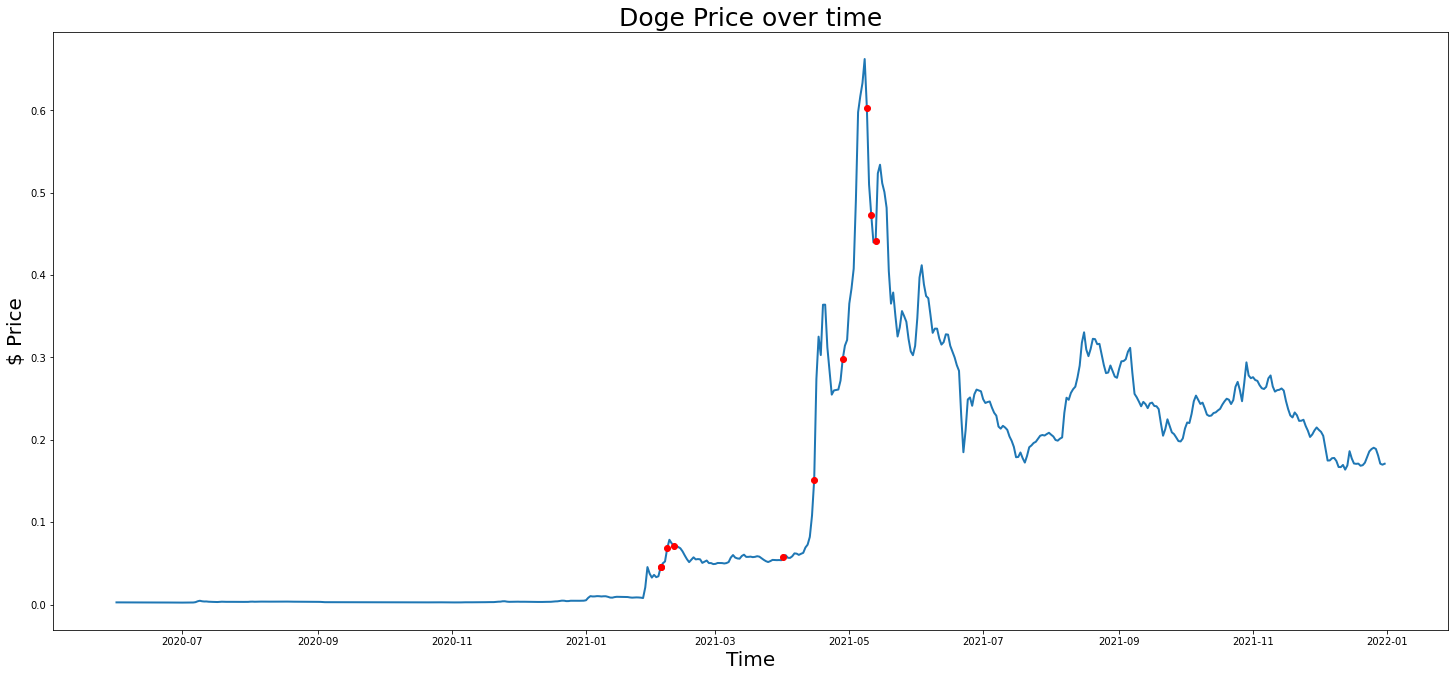

In [54]:
plt.figure(figsize = (25, 11))
plt.plot(df["Date"], df["Mean_Price"], lw=2)
plt.plot(df_tweets['Date'], df_tweets["Mean_Price"], '.r', markersize=12)
plt.title("Doge Price over time", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("$ Price", size=20)

Text(0, 0.5, 'Volume')

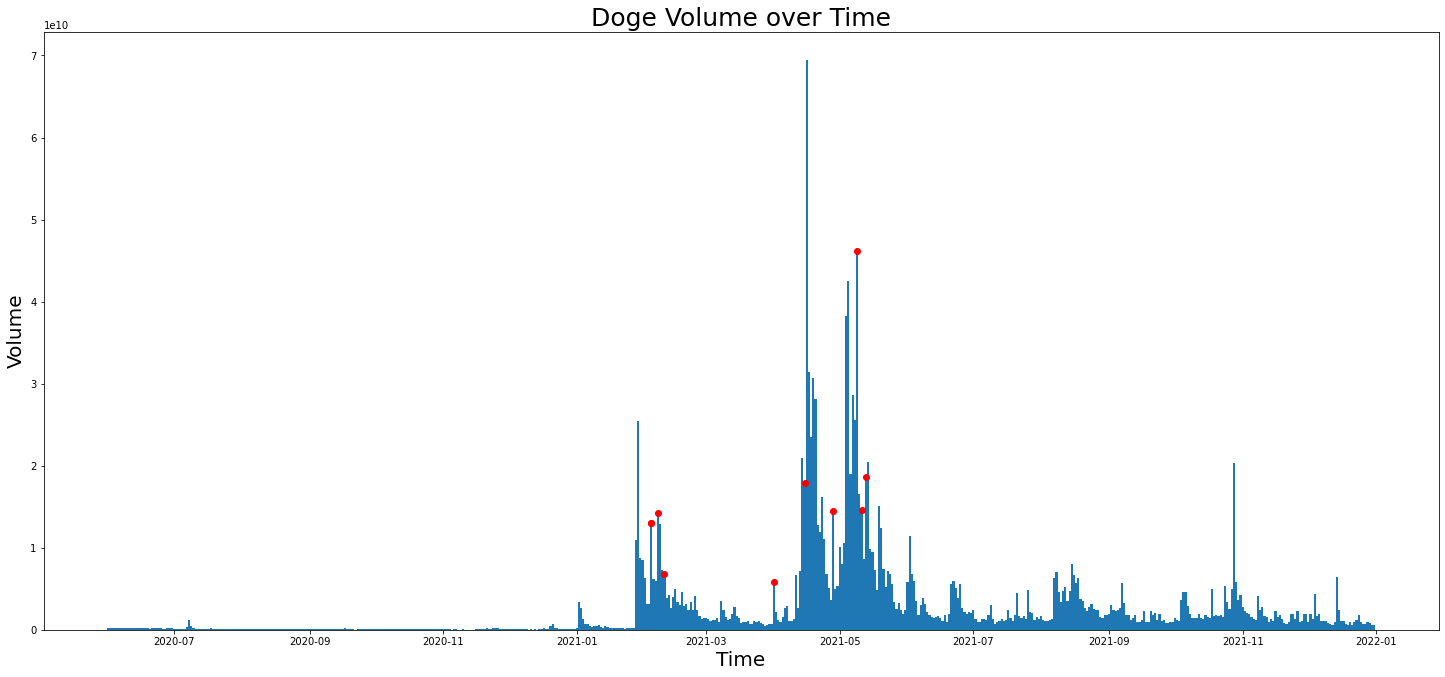

In [55]:
plt.figure(figsize = (25, 11))
plt.bar(df["Date"], df["Volume"], width=1)
plt.plot(df_tweets['Date'], df_tweets["Volume"], '.r', markersize=12)
plt.title("Doge Volume over Time", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("Volume", size=20)

In [76]:
def test_stationarity(x, log="non-stationary"):
    '''Test stationarity of a Time Series variable.'''
    
    # Perform Dickey Fuller test    
    result = adfuller(x)
    print('ADF Stastistic: %f'%result[0])
    print('p-value: %f'%result[1])
    pvalue=result[1]
    
    for key,value in result[4].items():
        if result[0]>value:
            print("The graph is non stationary! (it has a trend)")
            break
        else:
            print("The graph is stationary! (it doesn't have a trend)")
            break
    
    print('Critical values:')
    for key,value in result[4].items():
        print('\t%s: %.3f ' % (key, value))
    
    # Determing rolling statistics
    rolmean = x.rolling(window=22,center=False).mean()
    rolstd = x.rolling(window=12,center=False).std()
    
    # Plot rolling statistics:
    plt.figure(figsize=(25, 11))
    orig = plt.plot(x, lw=3, label='Original')
    mean = plt.plot(rolmean, lw=2.5, ls="--",  label='Rolling Mean')
    std = plt.plot(rolstd, lw=3, label = 'Rolling Std')
    plt.legend(loc='best', fontsize=20)
    plt.title('Rolling Mean & Standard Deviation', size=25)
    plt.show(block=False)
    

ADF Stastistic: -2.069770
p-value: 0.256842
The graph is non stationary! (it has a trend)
Critical values:
	1%: -3.442 
	5%: -2.867 
	10%: -2.570 


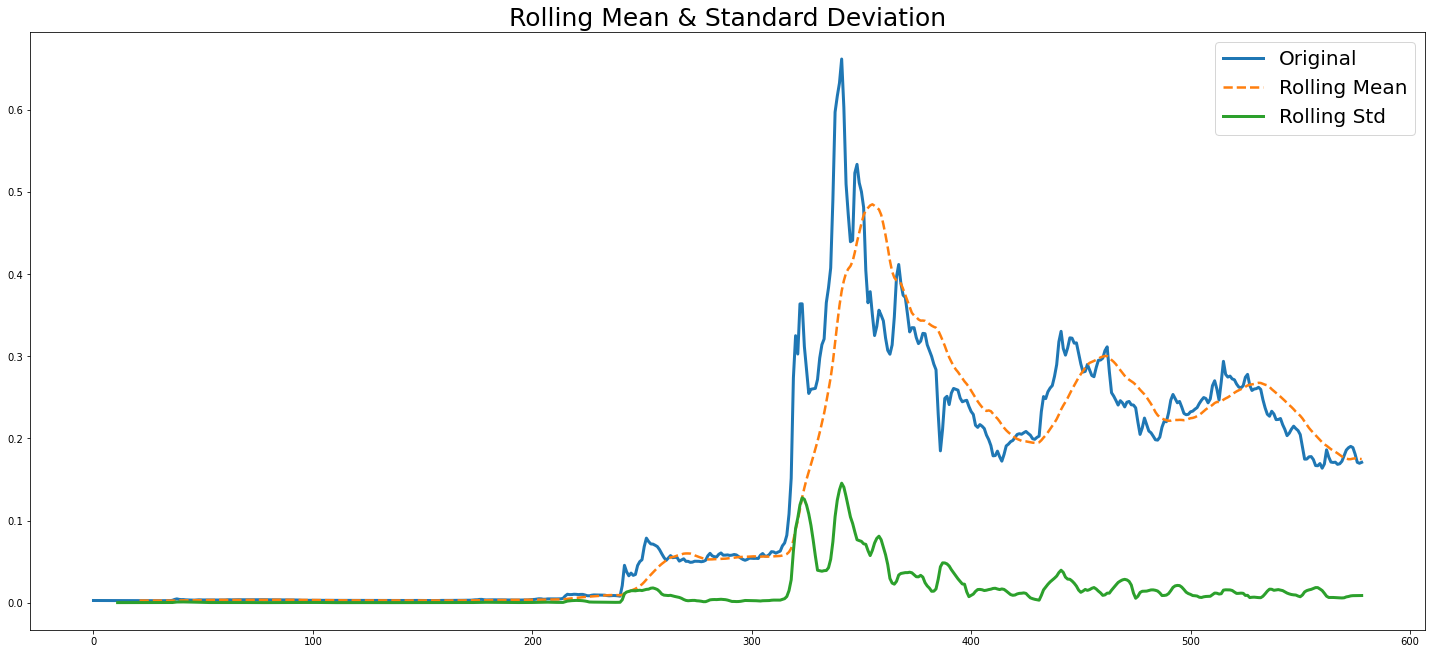

In [77]:
price = pd.Series(df["Mean_Price"].to_list())
test_stationarity(price, log="non-stationary")

ADF Stastistic: -4.716106
p-value: 0.000078
The graph is stationary! (it doesn't have a trend)
Critical values:
	1%: -3.442 
	5%: -2.867 
	10%: -2.570 


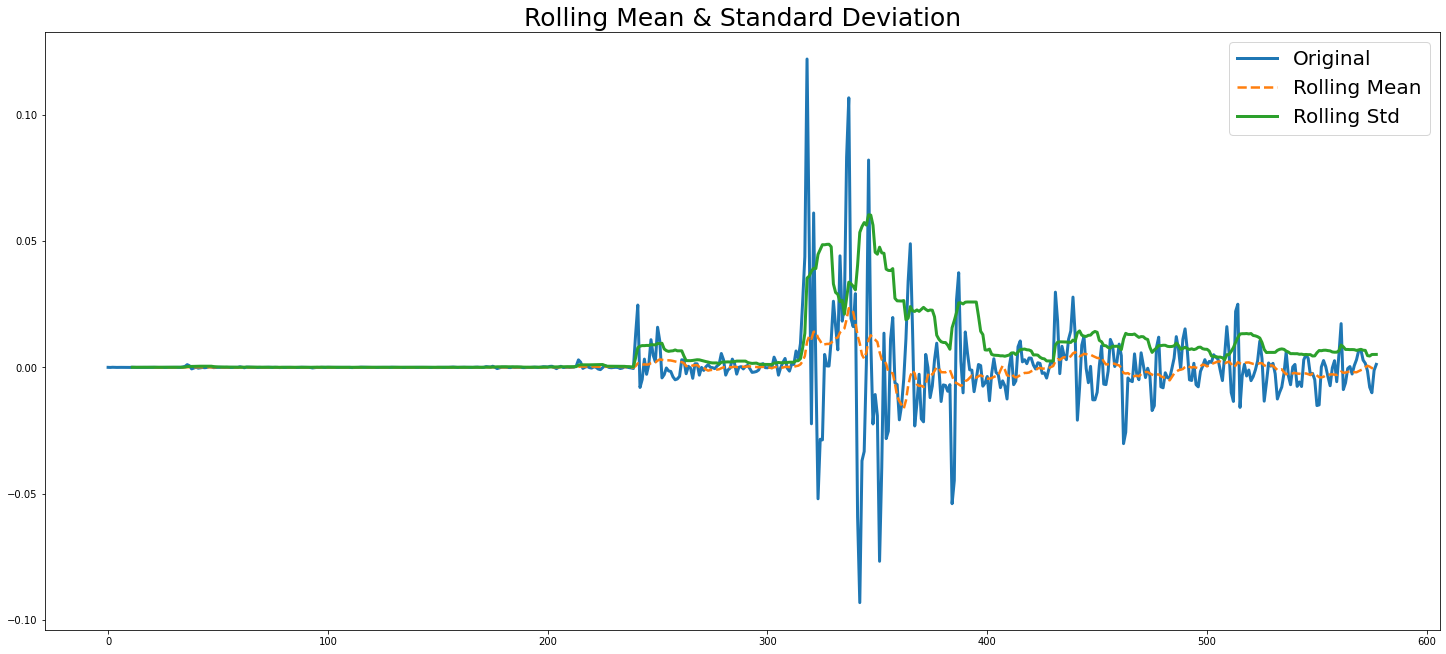

In [78]:
# Adjust by applying natural log over the series
d_price = []
price = price.to_list()
# log_price = log_price.to_list()

for i in range(1, len(price)):
    d_price.append(price[i] - price[i-1])

d_log_price = pd.Series(d_price)
test_stationarity(d_log_price, log="stationary")

ADF Stastistic: -1.046204
p-value: 0.736042
The graph is non stationary! (it has a trend)
Critical values:
	1%: -3.442 
	5%: -2.867 
	10%: -2.569 


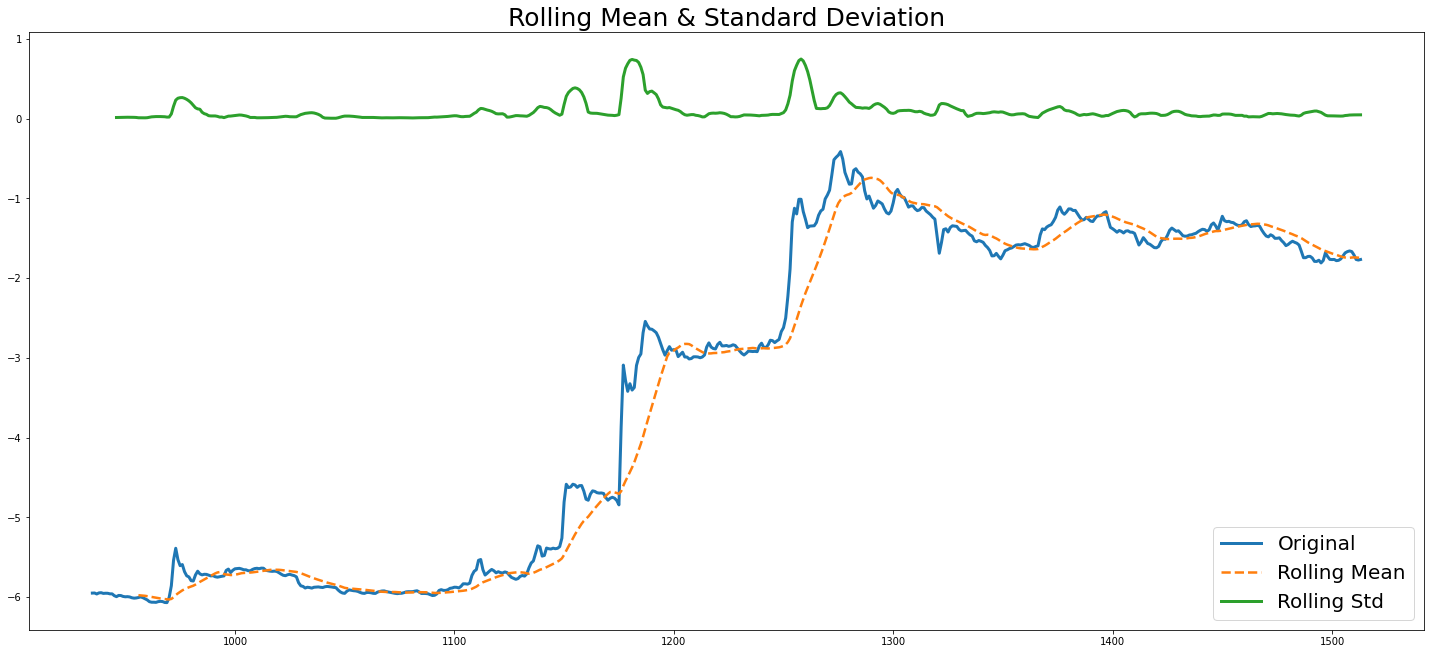

In [79]:
# Adjust by applying natural log over the series
log_price = np.log(df["Mean_Price"])

log_price = pd.Series(log_price)
test_stationarity(log_price, log="stationary")

ADF Stastistic: -9.396949
p-value: 0.000000
The graph is stationary! (it doesn't have a trend)
Critical values:
	1%: -3.442 
	5%: -2.867 
	10%: -2.569 


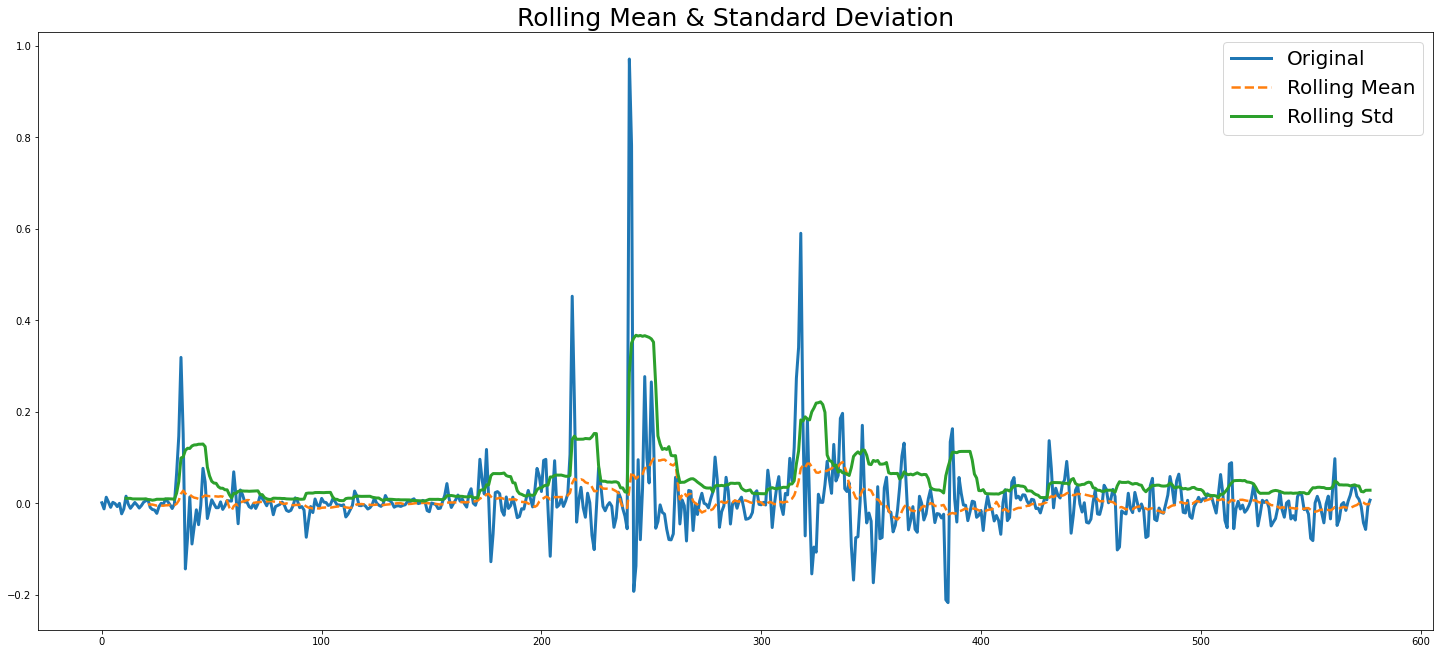

In [80]:
# Adjust by applying natural log over the series
d_log_price = []
log_price = log_price.to_list()
# log_price = log_price.to_list()

for i in range(1, len(log_price)):
    d_log_price.append(log_price[i] - log_price[i-1])

d_log_price = pd.Series(d_log_price)
test_stationarity(d_log_price, log="stationary")